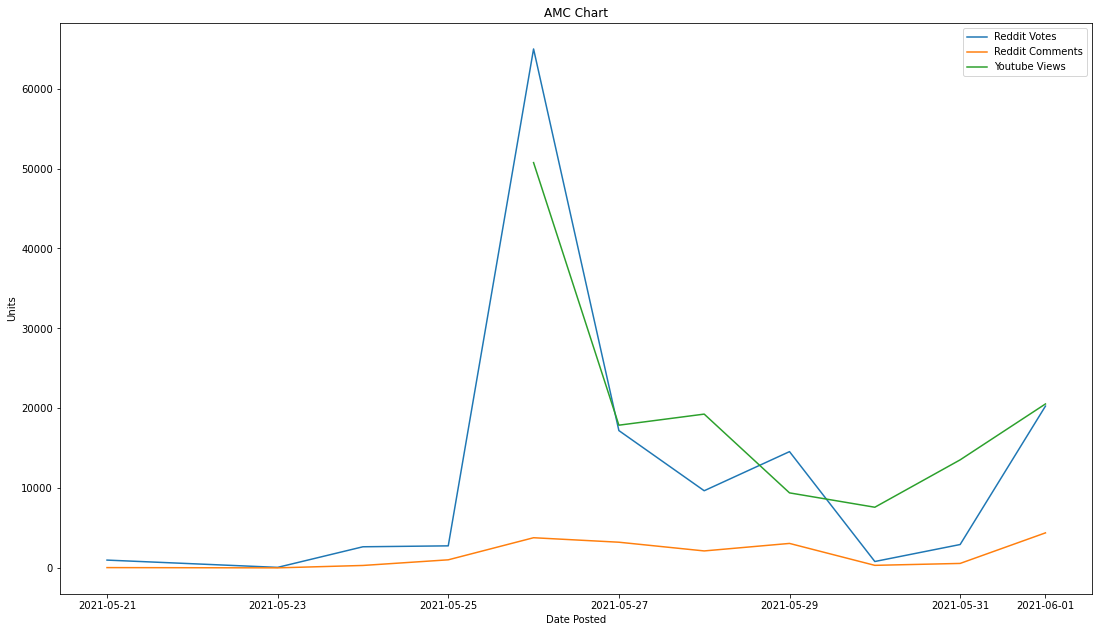

In [69]:
import mysql.connector
from matplotlib import pyplot as plt
import numpy as np
import collections

# returns connection object #
def connect_to_db(db_name):
    cnx = mysql.connector.connect(
    user='root',
    password='chalkHorseMountain',
    host='localhost',
    database=db_name
    )
    return cnx

# returns boolean #
def table_exists(cursor, tbl_name):
    cursor.execute("""
        SELECT COUNT(*)
        FROM information_schema.tables
        WHERE table_schema = DATABASE()
        AND table_name = \"""" + tbl_name + """\";
    """)
    
    if cursor.fetchone()[0] == 1:
        return True
    return False

    ## 'r_' indicates reddit attribute
    ## 'y_' indicates youtube attribute
class stock_hist(object):
    def __init__(self, symbol, r_votes, r_comments, r_dates, y_views, y_dates):
        self.symbol = symbol
        self.r_votes = r_votes
        self.r_comments = r_comments
        self.r_dates = r_dates
        self.y_views = y_views
        self.y_dates = y_dates

def get_hist(symbol, date_range):
    
    ## get reddit history ##
    cnx = connect_to_db("TheSpatula")
    mycursor = cnx.cursor()
    assert mycursor
    assert table_exists(mycursor, "reddit")
    
    mycursor.execute(f"""
        SELECT num_votes, num_comments, date_posted
        FROM reddit
        WHERE symbol="{symbol}"
        AND date_posted > "{date_range[0]}"
        AND date_posted < "{date_range[1]}"
        ;
        """)
    
    r_dict = collections.OrderedDict()
    ## r_dict = {"date":[votes, comments]} ##
    
    for (num_votes, num_comments, date_posted) in mycursor:
        if date_posted in r_dict.keys():
            r_dict[date_posted][0] += num_votes
            r_dict[date_posted][1] += num_comments
        
        else:
            r_dict[date_posted] = [num_votes, num_comments]
    
    mycursor.close()
    cnx.close()
    
    r_dict = collections.OrderedDict(sorted(r_dict.items()))
    
    ## get youtube history ##
    cnx = connect_to_db("TheSpatula")
    mycursor = cnx.cursor()
    assert mycursor
    assert table_exists(mycursor, "youtube")
    
    mycursor.execute(f"""
        SELECT num_views, date_posted
        FROM youtube
        WHERE symbol="{symbol}"
        AND date_posted > "{date_range[0]}"
        AND date_posted < "{date_range[1]}"
        ;
        """)
    
    y_dict = collections.OrderedDict()
    ## y_dict = {"date" : views} ##
    
    for (num_views, date_posted) in mycursor:
        if date_posted in y_dict.keys():
            y_dict[date_posted] += num_views/100
        else:
            y_dict[date_posted] = num_views/100
        
    mycursor.close()
    cnx.close()
    
    y_dict = collections.OrderedDict(sorted(y_dict.items()))
    
    r_votes = [vals[0] for vals in r_dict.values()]
    r_comments = [vals[1] for vals in r_dict.values()]
    r_dates = r_dict.keys()
    y_views = y_dict.values()
    y_dates = y_dict.keys()
    
    return stock_hist(symbol, r_votes, r_comments, r_dates, y_views, y_dates)

def plot_hist(symbol, date_range):
    hist = get_hist(symbol, date_range)
    
    plt.plot(hist.r_dates, hist.r_votes)
    plt.plot(hist.r_dates, hist.r_comments)
    plt.plot(hist.y_dates, hist.y_views)
    plt.title(f"{symbol} Chart")
    plt.xlabel("Date Posted")
    plt.ylabel("Units")
    plt.legend(["Reddit Votes", "Reddit Comments", "Youtube Views"])
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)

    
if __name__ == "__main__":
    
    plot_hist("AMC", ("2021-05-20", "2021-06-02"))
    